In [401]:
import numpy as np
import matplotlib.pyplot as plt

Q = pow(10, 3)    # process noise
R = pow(10, 4)    # gaussian noise
count_stream = []
count = np.random.normal(0, Q)
if count <= 0:
    count_stream.append(0)
else:
    count_stream.append(count)
while len(count_stream) < 1000:
    count = np.random.normal(count_stream[-1], Q)
    if count >= 0:
        count_stream.append(count)
        
count_stream = np.array(count_stream)

In [402]:
# Q = pow(10, 3)    # process noise
count_stream_2 = []

while len(count_stream_2) < 1000:
    count = np.random.normal(0, Q)
    if count >= 0:
        count_stream_2.append(count)
        
count_stream_2 = np.array(count_stream_2)

In [403]:
logistics = []
sins = []
A = 5000
b = np.pi / 6
c = np.pi / 2
for i in range(1, 1001):
    logistics.append(A / (1 + np.exp(-i)))
    sins.append(A * np.sin(b*i + c))

logistics = np.array(logistics)
sins = np.array(sins) + A * 1.1

In [404]:
import math

# Q = pow(10, 5)    # process noise
# R = pow(10, 6)    # gaussian noise
prior_P = 0    # initial prior error variance
post_P = 0    # initial posterior error variance
prior_x = 0    # initial prior estimate
post_x = 0     # initial posterior estimate
release = []
K = 0    # initial Kalman Gain
alpha = 0.01    # privacy budget
Cp = 0.9
Ci = 0.1
Cd = 0
interval = 1    # initial sampling interval
theta = 10
xi = 0.1
T = 5    # intergral time window
feed_error = [0,0,0,0]
sample_point = [0]
num_sample = 0

def l1_norm(r_list, x_list):
    return np.sum(abs(np.array(r_list) - np.array(x_list)))

def l2_norm(r_list, x_list):
    return np.sqrt(np.sum(pow(np.array(r_list) - np.array(x_list), 2)))

def linf_norm(r_list, x_list):
    return np.amax(abs(np.array(r_list) - np.array(x_list)))

def re(r_list, x_list):
    E = np.sum(abs(np.array(r_list) - np.array(x_list)) / np.maximum(x_list, 1)) / len(x_list)
    return E

def kf_predict(prev_r):
    global prior_x, prior_P
    prior_x = prev_r
    prior_P = post_P + Q
    
def kf_correct(z):
    global K, post_x, post_P
    K = prior_P / (prior_P + R)
    post_x = prior_x + K * (z - prior_x)
    post_P = (1 - K) * prior_P
    
def sample_interval(n):
    global interval
    feed_error.append(abs(post_x - prior_x) / max(post_x, 1))
    delta = Cp * feed_error[-1] + (sum(feed_error[n-1 : n+4]) * Ci) / T    # + Cd * (feed_error[-1] - feed_error[-2]) / (sample_point[-1] - sample_point[-2])
    try:
        interval = max(1, int(interval + theta * (1 - math.exp((delta - xi) / xi))))
    except OverflowError:
        interval = 1

def FAST(input_stream, M):
    global num_sample, K, prior_x, prior_P, post_x, post_P, interval
    feed_error = [0,0,0,0]
    sample_point = [0]
    num_sample = 0
    K = 0
    prior_P = 0   
    post_P = 0    
    prior_x = 0 
    post_x = 0
    interval = int(len(input_stream) / M)
    release.append(input_stream[0])    # let output at k = 0 be the real value of the stream[0]
    for i in range(len(input_stream)):
        kf_predict(release[i])
        
        if i != sample_point[-1] or num_sample > M:
            release.append(prior_x)
        else:
            num_sample += 1
            z = input_stream[i] + np.random.laplace(0, M / alpha)    # noise output
            kf_correct(z)
            if post_x >= 0:
                release.append(post_x)
            else:
                release.append(0)
            sample_interval(len(sample_point))
            sample_point.append(sample_point[-1] + interval)
            
    del release[0]
    
def FAST_2(input_stream):
    global num_sample, K, prior_x, prior_P, post_x, post_P
    num_sample = 0
    K = 0
    prior_P = 0   
    post_P = 0    
    prior_x = 0 
    post_x = 0
    release.append(input_stream[0])    # let output at k = 0 be the real value of the stream[0]
    for i in range(len(input_stream)):
        kf_predict(release[i])
        z = input_stream[i] + np.random.laplace(0, len(input_stream) / alpha)    # noise output
        kf_correct(z)
        if post_x >= 0:
            release.append(post_x)
        else:
            release.append(0)
            
    del release[0]

In [405]:
# alpha = 0.01 * 150
# release = []
# FAST(count_stream, 150)
# relative_error = re(release, count_stream)
# print('Result with traditional FAST, sample point = 150')
# print('relative error:', relative_error)
# print('L1-norm error:', l1_norm(release, count_stream))
# print('L2-norm error:', l2_norm(release, count_stream))
# print('Linfinity-norm error:', linf_norm(release, count_stream))

# plt.plot((np.arange(1000)+1), count_stream)
# plt.plot((np.arange(1000)+1), release)
# plt.legend(('count_stream', 'release'))
# plt.show()

Result with no sampling FAST
relative error: 0.4803187262814185
L1-norm error: 746919.6509790123
L2-norm error: 29880.789527631634
Linfinity-norm error: 3431.5768320206116


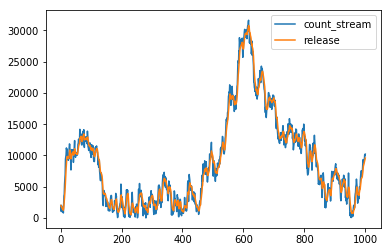

In [406]:
alpha = 0.01 * len(count_stream)
release = []
FAST_2(count_stream)
relative_error = re(release, count_stream)
print('Result with no sampling FAST')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, count_stream))
print('L2-norm error:', l2_norm(release, count_stream))
print('Linfinity-norm error:', linf_norm(release, count_stream))

plt.plot((np.arange(1000)+1), count_stream)
plt.plot((np.arange(1000)+1), release)
plt.legend(('count_stream', 'release'))
plt.show()

In [407]:
# alpha = 0.01
# perturbs = []
# for c in count_stream:
#     perturb = c + np.random.laplace(0, len(count_stream) / alpha)
#     if perturb > 0:
#         perturbs.append(perturb)
#     else:
#         perturbs.append(0)

# print('Result with only perturbation, epsilon = alpha / 1000')
# print('relative error:', re(perturbs, count_stream))
# print('L1-norm error:', l1_norm(perturbs, count_stream))
# print('L2-norm error:', l2_norm(perturbs, count_stream))
# print('Linfinity-norm error:', linf_norm(perturbs, count_stream))

# plt.plot((np.arange(1000)+1), count_stream)
# plt.plot((np.arange(1000)+1), perturbs)
# plt.legend(('count_stream', 'perturbs'))
# plt.show()

Result with only perturbation, epsilon = alpha
relative error: 0.03987312488193026
L1-norm error: 100161.86304487509
L2-norm error: 4442.115750966908
Linfinity-norm error: 741.6061488012697


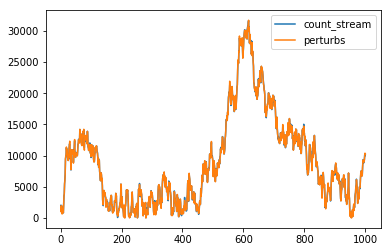

In [408]:
alpha = 0.01
perturbs = []
for c in count_stream:
    perturb = c + np.random.laplace(0, 1 / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

print('Result with only perturbation, epsilon = alpha')
print('relative error:', re(perturbs, count_stream))
print('L1-norm error:', l1_norm(perturbs, count_stream))
print('L2-norm error:', l2_norm(perturbs, count_stream))
print('Linfinity-norm error:', linf_norm(perturbs, count_stream))

plt.plot((np.arange(1000)+1), count_stream)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('count_stream', 'perturbs'))
plt.show()

Result with laplace + kalman filter, epsilon = 0.01
relative error: 0.2466983907700045
L1-norm error: 320476.3755227163
L2-norm error: 12785.28009321053
Linfinity-norm error: 1505.2769468346305


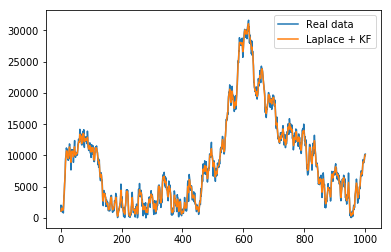

In [409]:
from pykalman import KalmanFilter

alpha = 0.01
perturbs = []
for c in count_stream:
    perturb = c + np.random.laplace(0, 1 / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

kf = KalmanFilter()        
state_mean, state_cov = kf.smooth(perturbs)
state_mean = np.reshape(state_mean, -1)

print('Result with laplace + kalman filter, epsilon = 0.01')
print('relative error:', re(state_mean, count_stream))
print('L1-norm error:', l1_norm(state_mean, count_stream))
print('L2-norm error:', l2_norm(state_mean, count_stream))
print('Linfinity-norm error:', linf_norm(state_mean, count_stream))

plt.plot((np.arange(1000)+1), count_stream)
# plt.plot((np.arange(1000)+1), perturbs)
plt.plot((np.arange(1000)+1), state_mean)
plt.legend(['Real data', 'Laplace + KF'])
plt.show()

In [410]:
# alpha = 0.01 * 150
# release = []
# sample_point = [0]
# num_sample = 0
# FAST(count_stream_2, 150)
# relative_error = re(release, count_stream_2)
# print('Result with traditional FAST, sample point = 150')
# print('relative error:', relative_error)
# print('L1-norm error:', l1_norm(release, count_stream_2))
# print('L2-norm error:', l2_norm(release, count_stream_2))
# print('Linfinity-norm error:', linf_norm(release, count_stream_2))

# plt.plot((np.arange(1000)+1), count_stream_2)
# plt.plot((np.arange(1000)+1), release)
# plt.legend(('count_stream_2', 'release'))
# plt.show()

Result with no sampling FAST
relative error: 4.295691379668497
L1-norm error: 374701.2275802469
L2-norm error: 15044.52435942729
Linfinity-norm error: 2118.412986428665


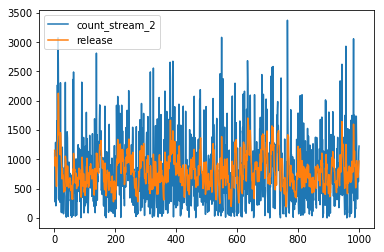

In [411]:
alpha = 0.01 * len(count_stream_2)
release = []
FAST_2(count_stream_2)
relative_error = re(release, count_stream_2)
print('Result with no sampling FAST')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, count_stream_2))
print('L2-norm error:', l2_norm(release, count_stream_2))
print('Linfinity-norm error:', linf_norm(release, count_stream_2))

plt.plot((np.arange(1000)+1), count_stream_2)
plt.plot((np.arange(1000)+1), release)
plt.legend(('count_stream_2', 'release'))
plt.show()

In [412]:
# perturbs = []
# for c in count_stream_2:
#     perturb = c + np.random.laplace(0, len(count_stream_2) / alpha)
#     if perturb > 0:
#         perturbs.append(perturb)
#     else:
#         perturbs.append(0)

# print('Result with only perturbation, epsilon = alpha / 1000')    
# print('relative error:', re(perturbs, count_stream_2))
# print('L1-norm error:', l1_norm(perturbs, count_stream_2))
# print('L2-norm error:', l2_norm(perturbs, count_stream_2))
# print('Linfinity-norm error:', linf_norm(perturbs, count_stream_2))

# plt.plot((np.arange(1000)+1), count_stream_2)
# plt.plot((np.arange(1000)+1), perturbs)
# plt.legend(('count_stream_2', 'perturbs'))
# plt.show()

Result with only perturbation, epsilon = alpha
relative error: 0.5132205131035487
L1-norm error: 91831.89158017878
L2-norm error: 4123.718015616836
Linfinity-norm error: 783.4251622706886


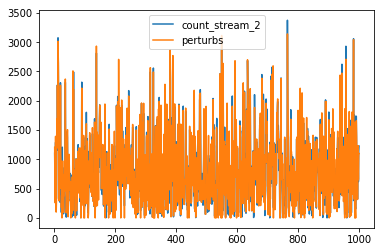

In [413]:
alpha = 0.01
perturbs = []
for c in count_stream_2:
    perturb = c + np.random.laplace(0, 1 / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

print('Result with only perturbation, epsilon = alpha')    
print('relative error:', re(perturbs, count_stream_2))
print('L1-norm error:', l1_norm(perturbs, count_stream_2))
print('L2-norm error:', l2_norm(perturbs, count_stream_2))
print('Linfinity-norm error:', linf_norm(perturbs, count_stream_2))

plt.plot((np.arange(1000)+1), count_stream_2)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('count_stream_2', 'perturbs'))
plt.show()

Result with laplace + kalman filter, epsilon = 0.01
relative error: 3.179218357777987
L1-norm error: 292214.41644927213
L2-norm error: 11658.598165107353
Linfinity-norm error: 1376.5361880021132


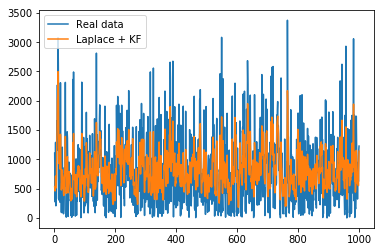

In [414]:
alpha = 0.01
perturbs = []
for c in count_stream_2:
    perturb = c + np.random.laplace(0, 1 / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

kf = KalmanFilter()        
state_mean, state_cov = kf.smooth(perturbs)
state_mean = np.reshape(state_mean, -1)

print('Result with laplace + kalman filter, epsilon = 0.01')
print('relative error:', re(state_mean, count_stream_2))
print('L1-norm error:', l1_norm(state_mean, count_stream_2))
print('L2-norm error:', l2_norm(state_mean, count_stream_2))
print('Linfinity-norm error:', linf_norm(state_mean, count_stream_2))

plt.plot((np.arange(1000)+1), count_stream_2)
plt.plot((np.arange(1000)+1), state_mean)
plt.legend(['Real data', 'Laplace + KF'])
plt.show()

In [415]:
# release = []
# sample_point = [0]
# num_sample = 0
# alpha = 0.01 * 150
# FAST(logistics, 150)
# relative_error = re(release, logistics)
# print('Result with traditional FAST, sample point = 150')
# print('relative error:', relative_error)
# print('L1-norm error:', l1_norm(release, logistics))
# print('L2-norm error:', l2_norm(release, logistics))
# print('Linfinity-norm error:', linf_norm(release, logistics))

# plt.plot((np.arange(1000)+1), logistics)
# plt.plot((np.arange(1000)+1), release)
# plt.legend(('logistics', 'release'))
# plt.show()

Result with no sampling FAST
relative error: 0.009541627116495782
L1-norm error: 47563.922531810975
L2-norm error: 2370.5232829934457
Linfinity-norm error: 753.5301114881031


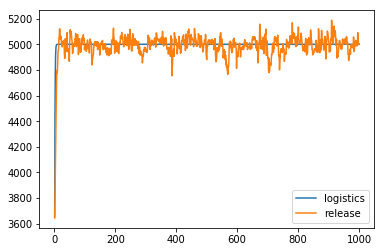

In [416]:
alpha = 0.01 * len(logistics)
release = []
FAST_2(logistics)
relative_error = re(release, logistics)
print('Result with no sampling FAST')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, logistics))
print('L2-norm error:', l2_norm(release, logistics))
print('Linfinity-norm error:', linf_norm(release, logistics))

plt.plot((np.arange(1000)+1), logistics)
plt.plot((np.arange(1000)+1), release)
plt.legend(('logistics', 'release'))
plt.show()

In [417]:
# alpha = 0.01 * len(logistics)
# perturbs = []
# for c in logistics:
#     perturb = c + np.random.laplace(0, len(logistics) / alpha)
#     if perturb > 0:
#         perturbs.append(perturb)
#     else:
#         perturbs.append(0)

# print('Result with only perturbation, epsilon = alpha / 1000')
# print('relative error:', re(perturbs, logistics))
# print('L1-norm error:', l1_norm(perturbs, logistics))
# print('L2-norm error:', l2_norm(perturbs, logistics))
# print('Linfinity-norm error:', linf_norm(perturbs, logistics))

# plt.plot((np.arange(1000)+1), logistics)
# plt.plot((np.arange(1000)+1), perturbs)
# plt.legend(('logistics', 'perturbs'))
# plt.show()

Result with only perturbation, epsilon = alpha
relative error: 0.019933627067787164
L1-norm error: 99604.1584648388
L2-norm error: 4452.2858414855555
Linfinity-norm error: 694.2364526991514


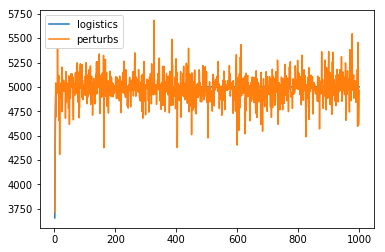

In [418]:
alpha = 0.01
perturbs = []
for c in logistics:
    perturb = c + np.random.laplace(0, 1 / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

print('Result with only perturbation, epsilon = alpha')
print('relative error:', re(perturbs, logistics))
print('L1-norm error:', l1_norm(perturbs, logistics))
print('L2-norm error:', l2_norm(perturbs, logistics))
print('Linfinity-norm error:', linf_norm(perturbs, logistics))

plt.plot((np.arange(1000)+1), logistics)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('logistics', 'perturbs'))
plt.show()

Result with laplace + kalman filter, epsilon = 0.01
relative error: 0.011234337952747612
L1-norm error: 55626.224472184316
L2-norm error: 2739.3898900087706
Linfinity-norm error: 1175.1748705277528


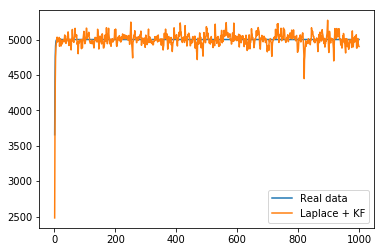

In [419]:
alpha = 0.01
perturbs = []
for c in logistics:
    perturb = c + np.random.laplace(0, 1 / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

kf = KalmanFilter()        
state_mean, state_cov = kf.smooth(perturbs)
state_mean = np.reshape(state_mean, -1)

print('Result with laplace + kalman filter, epsilon = 0.01')
print('relative error:', re(state_mean, logistics))
print('L1-norm error:', l1_norm(state_mean, logistics))
print('L2-norm error:', l2_norm(state_mean, logistics))
print('Linfinity-norm error:', linf_norm(state_mean, logistics))

plt.plot((np.arange(1000)+1), logistics)
plt.plot((np.arange(1000)+1), state_mean)
plt.legend(['Real data', 'Laplace + KF'])
plt.show()

In [420]:
# release = []
# sample_point = [0]
# num_sample = 0
# alpha = 0.01 * 150
# FAST(sins, 150)
# relative_error = re(release, sins)
# print('Result with traditional FAST, M = 150')
# print('relative error:', relative_error)
# print('L1-norm error:', l1_norm(release, sins))
# print('L2-norm error:', l2_norm(release, sins))
# print('Linfinity-norm error:', linf_norm(release, sins))

# plt.plot((np.arange(1000)+1), sins)
# plt.plot((np.arange(1000)+1), release)
# plt.legend(('sins', 'release'))
# plt.show()

Result with no sampling FAST
relative error: 1.1644203463587974
L1-norm error: 2278747.560960717
L2-norm error: 81677.76520962708
Linfinity-norm error: 4654.439234960029


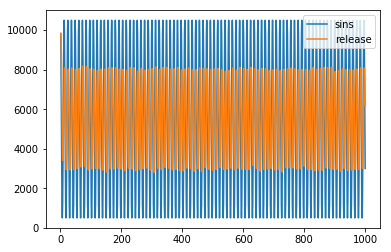

In [421]:
release = []
alpha = 0.01 * len(sins)
FAST_2(sins)
relative_error = re(release, sins)
print('Result with no sampling FAST')
print('relative error:', relative_error)
print('L1-norm error:', l1_norm(release, sins))
print('L2-norm error:', l2_norm(release, sins))
print('Linfinity-norm error:', linf_norm(release, sins))

plt.plot((np.arange(1000)+1), sins)
plt.plot((np.arange(1000)+1), release)
plt.legend(('sins', 'release'))
plt.show()

In [422]:
# perturbs = []
# for c in sins:
#     perturbs.append(c + np.random.laplace(0, len(sins) / alpha))
    
# print('Result with only perturbation, epsilon = alpha / 1000')
# print('relative error:', re(perturbs, sins))
# print('L1-norm error:', l1_norm(perturbs, sins))
# print('L2-norm error:', l2_norm(perturbs, sins))
# print('Linfinity-norm error:', linf_norm(perturbs, sins))

# plt.plot((np.arange(1000)+1), sins)
# plt.plot((np.arange(1000)+1), perturbs)
# plt.legend(('sins', 'perturbs'))
# plt.show()

Result with only perturbation, epsilon = alpha
relative error: 0.045117666152903114
L1-norm error: 99504.8428037024
L2-norm error: 4427.00020224642
Linfinity-norm error: 807.2029540103686


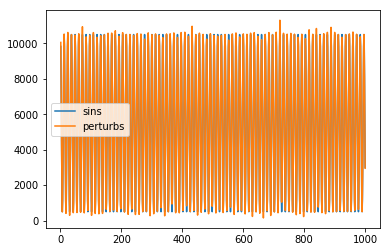

In [423]:
alpha = 0.01
perturbs = []
for c in sins:
    perturbs.append(c + np.random.laplace(0, 1 / alpha))
    
print('Result with only perturbation, epsilon = alpha')
print('relative error:', re(perturbs, sins))
print('L1-norm error:', l1_norm(perturbs, sins))
print('L2-norm error:', l2_norm(perturbs, sins))
print('Linfinity-norm error:', linf_norm(perturbs, sins))

plt.plot((np.arange(1000)+1), sins)
plt.plot((np.arange(1000)+1), perturbs)
plt.legend(('sins', 'perturbs'))
plt.show()

Result with laplace + kalman filter, epsilon = 0.01
relative error: 0.3781858787761541
L1-norm error: 674960.0149107872
L2-norm error: 24341.102539376934
Linfinity-norm error: 4634.1519270326335


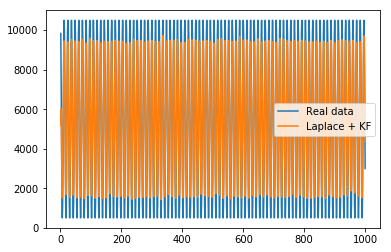

In [424]:
alpha = 0.01
perturbs = []
for c in sins:
    perturb = c + np.random.laplace(0, 1 / alpha)
    if perturb > 0:
        perturbs.append(perturb)
    else:
        perturbs.append(0)

kf = KalmanFilter()        
state_mean, state_cov = kf.smooth(perturbs)
state_mean = np.reshape(state_mean, -1)

print('Result with laplace + kalman filter, epsilon = 0.01')
print('relative error:', re(state_mean, sins))
print('L1-norm error:', l1_norm(state_mean, sins))
print('L2-norm error:', l2_norm(state_mean, sins))
print('Linfinity-norm error:', linf_norm(state_mean, sins))

plt.plot((np.arange(1000)+1), sins)
plt.plot((np.arange(1000)+1), state_mean)
plt.legend(['Real data', 'Laplace + KF'])
plt.show()

In [425]:
# import csv

# counts = []

# with open('C:\\Users\\user\Downloads\\region_data.csv') as csvfile:
#     rows = csv.reader(csvfile)
    
#     for row in rows:
#         counts.append(row)

In [426]:
# counts = counts[3:]
# for i in range(len(counts)):
#     counts[i] = counts[i][1:]
#     counts[i] = list(map(int, counts[i]))

In [427]:
# releases = []
# alpha = 0.01 * 150
# for count in counts:
#     release = []
#     FAST(count, 150)
#     releases.append(release)

In [428]:
# import csv

# with open('output.csv', 'w') as csvfile:
#     writer = csv.writer(csvfile)
    
#     writer.writerow(['', 'timestamp', 'region', 'real_count', 'release_count'])
#     for i in range(len(releases[0]) * len(releases)):
#         writer.writerow([i, (i % 673), int(i / 673), counts[int(i / 673)][(i % 673)], releases[int(i / 673)][(i % 673)]])

In [429]:
# print('Result with FAST, M = ', 150, 'epsilon = ', alpha)
# print('relative error:', re(releases[0], counts[0]))
# print('L1-norm error:', l1_norm(releases[0], counts[0]))
# print('L2-norm error:', l2_norm(releases[0], counts[0]))
# print('Linfinity-norm error:', linf_norm(releases[0], counts[0]))

# plt.plot((np.arange(len(counts[0]))), counts[0])
# plt.plot((np.arange(len(counts[0]))), releases[0])
# plt.legend(('real count', 'release'))
# plt.show()

In [430]:
# alpha = 0.01 * len(counts[0])
# release = []
# FAST_2(counts[0])

# print('Result with no sampling FAST, epsilon = ', alpha)
# print('relative error:', re(release, counts[0]))
# print('L1-norm error:', l1_norm(release, counts[0]))
# print('L2-norm error:', l2_norm(release, counts[0]))
# print('Linfinity-norm error:', linf_norm(release, counts[0]))

# plt.plot((np.arange(len(counts[0]))), counts[0])
# plt.plot((np.arange(len(counts[0]))), release)
# plt.legend(('real count', 'release'))
# plt.show()

In [431]:
# import numpy as np

# perturbs = []
# alpha = 0.01
# for i in range(len(counts[0])):
#     perturb = counts[0][i] + np.random.laplace(0, 1 / alpha)
#     if i > 3 and np.mean(perturbs[-3:]) != 0:
#         perturb = (perturb + np.sum(perturbs[-3:])) / 4
#     if perturb >= 0:
#         perturbs.append(perturb)
#     else:
#         perturbs.append(0)
    
# print('Result with only perturbation, epsilon = ', alpha)
# print('relative error:', re(perturbs, counts[0]))
# print('L1-norm error:', l1_norm(perturbs, counts[0]))
# print('L2-norm error:', l2_norm(perturbs, counts[0]))
# print('Linfinity-norm error:', linf_norm(perturbs, counts[0]))

# plt.plot((np.arange(len(counts[0]))), counts[0])
# plt.plot((np.arange(len(counts[0]))), perturbs)
# plt.legend(('real count', 'perturbs'))
# plt.show()